# Segmenting and Clustering Neighborhoods in Toronto

## First question

Let's first get the table from Wikipedia page using BeautifulSoup.

In [1]:
# Import the necessary libraries
import requests
from bs4 import BeautifulSoup

In [2]:
#Define the URL from where we will retrieve the data
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(URL)

In [3]:
#Get page content in lxml and extract only the necessary class
soup = BeautifulSoup(page.content, 'lxml')
My_table = soup.find('table',{'class':'wikitable sortable'})
links = My_table.findAll('th')
tr = My_table.findAll(['tr'])

In [4]:
# Create a csv file with the result of parsing the content of the page
import csv
csvFile = open("toronto_neighborhoods.csv",'wt',newline='',encoding='utf-8')
writer = csv.writer(csvFile)  
try:   
        for cell in tr:
            th = cell.find_all('th')
            th_data = [col.text.strip('\n') for col in th]
            td = cell.find_all('td')
            row = [i.text.replace('\n','') for i in td]
            writer.writerow(th_data+row)      
        
finally:   
    csvFile.close()

Now that we saved the data extracted from Wikipedia in a CSV file, let's import it as a dataframe.

In [15]:
# Import the data in the csv file to a dataframe
import pandas as pd
df = pd.read_csv("toronto_neighborhoods.csv")

In [16]:
#Visualise top 11 rows of the dataframe
df.head(12)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


Let's preprocess the data we extracted from Wikipedia:
* Remove lines with Not assigned Borough
* Combine rows of same Borough on the same line separated by commas
* Replace the Neighbourhood by the Borough in case the Neighbourhood is Not assigned

In [17]:
#Remove lines with Not assigned Borough
df = df[df['Borough']!="Not assigned"]

#Combine rows of same Borough on the same line comma separated
df.set_index(['Postal Code','Borough'],inplace=True)
df = df.groupby(level=['Postal Code','Borough'], sort=False).agg( ','.join)
df.reset_index(['Postal Code','Borough'],inplace=True)

# Set Neighborhood = Borough when Neighbourhood is Not assigned
import numpy as np
df['Neighbourhood'] = np.where((df['Neighbourhood'] == 'Not assigned'),df['Borough'],df['Neighbourhood'])

In [18]:
#Visualise first 11 rors of the dataframe
df.head(12)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [19]:
# Get number of rows and columns in the dataframe
df.shape

(103, 3)

## Second question

Now we need to retrieve the latitude and longitude for these postal codes.

Let's import the csv file with the latitude and longitude for each neighborhood.

In [20]:
#Import csv file with latitude and longitude coordinates of Toronto
df_ll = pd.read_csv("Geospatial_Coordinates.csv")
df_ll.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we need to add latitude and longitude to the data retrieved from Wikipedia.

In [21]:
# Add latitude and longitude to the data retrieved fro Wikipedia
df = pd.merge(df,df_ll,on='Postal Code', how='inner')
df.head(12)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Third question

#### Create a map of Toronto with neighbourhoods superimposed on top.

In [22]:
import folium

Let's first visualise Toronto and mark the neighbourhoods. 
So, let's use geopy library to get the latitude and longitude values of Toronto.

In [23]:
#Get latitude and longitude of the city of Toronto that will be used to center the map
from geopy.geocoders import Nominatim

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [24]:
# create map of Canada using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Let's filter our dataframe and keep only the Boroughs that contain the word "Toronto".

In [25]:
#Filter the dataframe to keep only Boroughs that contain the word Toronto
df_toronto = df[df['Borough'].str.contains('Toronto', regex=True)]
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


Let's visualize Toronto and the neighborhoods that contain the word Toronto in it.

In [26]:
# create map of Toronto using latitude and longitude values
map_toronto_f = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_f)  
    
map_toronto_f

Next, we are going to start using the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [54]:
CLIENT_ID = 'ST#####' # your Foursquare ID
CLIENT_SECRET = 'UHL#####' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ST#####
CLIENT_SECRET:UHL#####


#### Let's create a function to get the venues and categories of the Toronto neighborhoods

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [30]:
print(toronto_venues.shape)
toronto_venues.head()

(1642, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Let's check how many venues were returned for each neighborhood

In [31]:
toronto_venues.groupby('Neighborhood').count()['Venue']

Neighborhood
Berczy Park                                                                                                    58
Brockton, Parkdale Village, Exhibition Place                                                                   24
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto                           18
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     17
Central Bay Street                                                                                             62
Christie                                                                                                       17
Church and Wellesley                                                                                           76
Commerce Court, Victoria Hotel                                                                                100
Davisville                                                                 

#### Let's find out how many unique categories can be curated from all the returned venues

In [32]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


## Analyze Each Neighborhood

In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
toronto_onehot.shape

(1642, 234)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.017241,0.000000,0.000000,0.000000,0.000000,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Business reply mail Processing Centre, South C...",0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.016129,0.000000,0.000000,0.016129,0.000000,0.00
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Church and Wellesley,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,...,0.013158,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.00
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029412,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


### Let's confirm the new size

In [36]:
toronto_grouped.shape

(39, 234)

#### Let's print each neighborhood along with the top 5 most common venues

In [37]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.03
2      Farmers Market  0.03
3         Cheese Shop  0.03
4  Seafood Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.12
1          Bakery  0.08
2     Coffee Shop  0.08
3       Nightclub  0.08
4  Breakfast Spot  0.08


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.06
2         Auto Workshop  0.06
3  Fast Food Restaurant  0.06
4        Farmers Market  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3       Coffee Shop  0.06
4  Sculpture Garden  0.06


----Central Bay Street----
                venue  freq
0       

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Pub,Cheese Shop,Restaurant,Seafood Restaurant,Farmers Market,Beer Bar,Bakery,Café
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Bakery,Climbing Gym,Stadium,Burrito Place,Restaurant,Gym
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Recording Studio,Restaurant,Fast Food Restaurant,Auto Workshop,Farmers Market,Burrito Place,Pizza Place,Garden
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Bar,Boat or Ferry
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,New American Restaurant,Modern European Restaurant


## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [40]:
from sklearn.cluster import KMeans

In [41]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Let's use the elbow method with the calinski_harabasz score to find out the optimal number of clusters

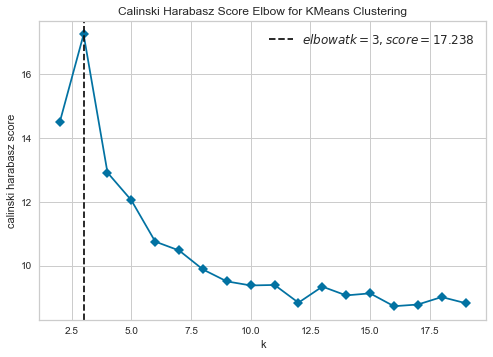

In [46]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,20), metric='calinski_harabasz', timings=False
)

visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

We can see from the above figure that the optimal number of clusters is 3, so let's run K-means to get these 3 clusters.

In [47]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Café,Bakery,Pub,Breakfast Spot,Restaurant,Theater,Dessert Shop,Shoe Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Gym,Distribution Center,Portuguese Restaurant,Persian Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Pizza Place,Fast Food Restaurant,Bookstore,Hotel
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gym,Cosmetics Shop,Restaurant,Moroccan Restaurant,Lingerie Store,Beer Bar
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Asian Restaurant,Pub,Health Food Store,Trail,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


Finally, let's visualize the resulting clusters

In [49]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster.

### Cluster 1 - Coffee Shops

Coffee Shops are common among the neighborhoods of the first cluster that is the biggest cluster generated. Looking into the most common venues it seems that these neighborhoods have a lot of services available like coffee shops,restaurants, hotels...

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Park,Café,Bakery,Pub,Breakfast Spot,Restaurant,Theater,Dessert Shop,Shoe Store
4,Downtown Toronto,0,Coffee Shop,Gym,Distribution Center,Portuguese Restaurant,Persian Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop
9,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Pizza Place,Fast Food Restaurant,Bookstore,Hotel
15,Downtown Toronto,0,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gym,Cosmetics Shop,Restaurant,Moroccan Restaurant,Lingerie Store,Beer Bar
19,East Toronto,0,Asian Restaurant,Pub,Health Food Store,Trail,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
20,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Pub,Cheese Shop,Restaurant,Seafood Restaurant,Farmers Market,Beer Bar,Bakery,Café
24,Downtown Toronto,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Japanese Restaurant,New American Restaurant,Modern European Restaurant
25,Downtown Toronto,0,Grocery Store,Café,Park,Diner,Baby Store,Candy Store,Restaurant,Coffee Shop,Nightclub,Athletics & Sports
30,Downtown Toronto,0,Coffee Shop,Café,Gym,Restaurant,Clothing Store,Hotel,Bar,Thai Restaurant,Lounge,Salad Place
31,West Toronto,0,Pharmacy,Bakery,Music Venue,Bank,Supermarket,Café,Smoke Shop,Art Gallery,Middle Eastern Restaurant,Park


### Cluster 2 - Garden

This cluster has only one element and the most common venue on this neighborhood and that distinguishs it from the others are the gardens.

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,1,Garden,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


### Cluster 3  - Parks

The thrird and last cluster generated has 4 neighbourhoods that have in common the fact that Parks are between the most common venues.

In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,2,Park,Swim School,Bus Line,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
68,Central Toronto,2,Bus Line,Park,Jewelry Store,Trail,Sushi Restaurant,Women's Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
83,Central Toronto,2,Lawyer,Playground,Park,Gift Shop,German Restaurant,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
91,Downtown Toronto,2,Park,Playground,Trail,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
